In [1]:
import os
import matplotlib.pylab as plt
from matplotlib.patches import Rectangle
import numpy as np


import DL_Sequence

import multiprocessing

from ipywidgets import Layout, interact, IntSlider, FloatSlider
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # Report only TF errors by default

import DL_Sequence
import iSCAT_Datasets

num_classes = 8

exD=5000
devD=2000
exPT_cnt=170
devPT_cnt=140
exIntensity=1.0
devIntensity=0.4

res=64
frames=512
target_frame=15

number_of_threads = multiprocessing.cpu_count()


epoch_size = 16
batch_size = 4
verbose = 2
regen = False

dataset = DL_Sequence.iSCAT_DataGenerator(batch_size=batch_size, epoch_size=epoch_size, res=res, frames=frames, thread_count=number_of_threads * 2 // 3,
                    PSF_path="../PSF_subpx_fl32.npy", exD=exD, devD=devD, exPT_cnt=exPT_cnt, devPT_cnt=devPT_cnt, exIntensity=exIntensity, devIntensity=devIntensity, target_frame=target_frame,
                    num_classes=num_classes, verbose = verbose, noise_func = None, mode = "dynamic", regen = regen)

data = dataset.samples
targets = dataset.particles_in_sight_cnt
target_masks = dataset.target_masks
poss = dataset.particle_positions
pt_cnts = dataset.pt_cnts
dataset.destroy()

inference_frame_cnt = 32

2023-06-20 16:05:31.548117: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-20 16:05:32.835957: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/labadmin/miniconda3/envs/DeepLearning/lib/
2023-06-20 16:05:32.838308: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/labadmin/miniconda3/envs/DeepLearning/lib/
2023-06-20 16:05:32.838315: W 

Sample width:  448
particlesWorker: Run
Particle generation time: 0.174s
Sparse Subpixel Convolution initialized
Preparation of memory took 1012 ms
Preparation of memory took 0 ms
sampleWorker:particlesWorker: Run 
Run

OMP max threads: 64
OMP setting number of threads to 42
Particle generation time: 0.250s
Conv generation time: 1.506s
Target generation time: 0.001s
Whole generation time: 1.586s
Computation of convolutions took 1392 ms

OMP max threads: 42
OMP setting number of threads to 42
Computation of convolutions took 44 ms
Min particle in sight cnt: 1
Max particle in sight cnt: 7
Avg particle in sight cnt: 2.5625
Std particle in sight cnt: 1.6944302139657448
class: 0     |1     |2     |3     |4     |5     |6     |7     |
count: 0     |5     |5     |3     |0     |2     |0     |1     |
sampleWorker:particlesWorker:  DieDie



In [2]:
import tensorflow as tf

print(tf.keras.backend.image_data_format())
tf.keras.backend.set_image_data_format('channels_first')
print(tf.keras.backend.image_data_format())
    

class ResNet(tf.keras.Model):    
    def _cnn(self, inputs, filters, kernel_size, stride, activation):
        hidden = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same", use_bias=False)(inputs)
        hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = tf.keras.layers.Activation(tf.nn.swish)(hidden) if activation else hidden
        return hidden

    def _block(self, inputs, filters, stride, layer_index):
        hidden = self._cnn(inputs, filters, self.kernel_size, stride, activation=True)
        hidden = self._cnn(hidden, filters, self.kernel_size, 1, activation=False)
           
        residual = self._cnn(inputs, filters, 1, stride, activation=False) if stride > 1 else inputs
        
        hidden = residual + hidden
        hidden = tf.keras.layers.Activation(tf.nn.swish)(hidden)
        return hidden

    def __init__(self, shape, num_classes, depth, filters_start, kernel_size):
        self.shape = shape
        self.num_classes = num_classes
        self.depth = depth

        self.filters_start = filters_start
        self.kernel_size = kernel_size

        n = (depth - 2) // 6

        inputs = tf.keras.Input(shape=shape, dtype=tf.float32)
        hidden = self._cnn(inputs, filters_start, kernel_size, 1, activation=True)
        for stage in range(3):
            for block in range(n):
                hidden = self._block(hidden, filters_start * (1 << stage), 2 if stage > 0 and block == 0 else 1, (stage * n + block) / (3 * n - 1))
        hidden = tf.keras.layers.GlobalAvgPool2D()(hidden)
        outputs = tf.keras.layers.Dense(num_classes, activation=tf.nn.softmax)(hidden)

        super().__init__(inputs, outputs)



def create_and_load_model():
    dataset = 0
    
    depth = 62
    kernel_size = 3

    backbone_comment = "_dataset-" + str(dataset)
    backbone_name = "backbones/model_resnet_k" + str(kernel_size) + backbone_comment

    backbone = ResNet((inference_frame_cnt, res, res), num_classes, depth, inference_frame_cnt, kernel_size)
    backbone.load_weights(backbone_name + "_weights/")
    backbone.trainable = False
    
    backbone.summary()

    # (128, 16, 16), (64, 32, 32), (32, 64, 64)
    backbone = tf.keras.Model(
        inputs=backbone.input,
        outputs=[backbone.get_layer(layer).output for layer in [
                "activation_60", "activation_40", "activation_20"]]
    )

    def cnn_layer(inputs, filters, kernel_size, stride, activation):
        hidden = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=stride, padding="same", use_bias=False)(inputs)
        hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = tf.keras.layers.Activation(tf.nn.swish)(hidden) if activation else hidden
        return hidden

    filters = [128, 64, 32]
    hidden = backbone.outputs[0]
    cnn_blocks = 30
    for ii in range(len(backbone.outputs) - 1):
        conv = backbone.outputs[ii + 1]
        channels = filters[ii + 1]

        conv = tf.keras.layers.Conv2D(channels, kernel_size=1)(conv)
        hidden = tf.keras.layers.Conv2DTranspose(channels, kernel_size=2, strides=2, padding="same")(hidden)
        hidden = tf.keras.layers.Concatenate(axis=1)([hidden, conv])
        hidden = tf.keras.layers.BatchNormalization()(hidden)
        hidden = tf.keras.layers.Activation(tf.nn.swish)(hidden)

        hidden = cnn_layer(hidden, channels, 3, 1, True)
        for i in range(cnn_blocks):
            residual = hidden
            hidden = cnn_layer(hidden, channels, 3, 1, True)
            hidden = cnn_layer(hidden, channels, 3, 1, False)
            hidden += residual
            hidden = tf.keras.layers.Activation(tf.nn.swish)(hidden)

    outputs = tf.keras.layers.Conv2D(1, kernel_size=3, padding="same", activation=tf.nn.sigmoid)(hidden)

    model = tf.keras.Model(inputs=backbone.inputs, outputs=outputs)
    
    model_name = "models/resnet_unet"
    model.load_weights(model_name + "_weights/")
    
    return model

channels_last
channels_first


In [3]:
model = create_and_load_model()

Model: "res_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 64, 64)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 32, 64, 64)   9216        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 64, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

 batch_normalization_9 (BatchNo  (None, 32, 64, 64)  256         ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 32, 64, 64)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 32, 64, 64)   9216        ['activation_9[0][0]']           
                                                                                                  
 batch_normalization_10 (BatchN  (None, 32, 64, 64)  256         ['conv2d_10[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf.__oper

 conv2d_19 (Conv2D)             (None, 32, 64, 64)   9216        ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 32, 64, 64)  256         ['conv2d_19[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_19 (Activation)     (None, 32, 64, 64)   0           ['batch_normalization_19[0][0]'] 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 32, 64, 64)   9216        ['activation_19[0][0]']          
                                                                                                  
 batch_normalization_20 (BatchN  (None, 32, 64, 64)  256         ['conv2d_20[0][0]']              
 ormalizat

 ormalization)                                                                                    
                                                                                                  
 tf.__operators__.add_13 (TFOpL  (None, 64, 32, 32)  0           ['activation_26[0][0]',          
 ambda)                                                           'batch_normalization_29[0][0]'] 
                                                                                                  
 activation_28 (Activation)     (None, 64, 32, 32)   0           ['tf.__operators__.add_13[0][0]']
                                                                                                  
 conv2d_30 (Conv2D)             (None, 64, 32, 32)   36864       ['activation_28[0][0]']          
                                                                                                  
 batch_normalization_30 (BatchN  (None, 64, 32, 32)  128         ['conv2d_30[0][0]']              
 ormalizat

                                                                                                  
 batch_normalization_39 (BatchN  (None, 64, 32, 32)  128         ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 tf.__operators__.add_18 (TFOpL  (None, 64, 32, 32)  0           ['activation_36[0][0]',          
 ambda)                                                           'batch_normalization_39[0][0]'] 
                                                                                                  
 activation_38 (Activation)     (None, 64, 32, 32)   0           ['tf.__operators__.add_18[0][0]']
                                                                                                  
 conv2d_40 (Conv2D)             (None, 64, 32, 32)   36864       ['activation_38[0][0]']          
          

                                                                                                  
 batch_normalization_49 (BatchN  (None, 128, 16, 16)  64         ['conv2d_49[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_47 (Activation)     (None, 128, 16, 16)  0           ['batch_normalization_49[0][0]'] 
                                                                                                  
 conv2d_50 (Conv2D)             (None, 128, 16, 16)  147456      ['activation_47[0][0]']          
                                                                                                  
 batch_normalization_50 (BatchN  (None, 128, 16, 16)  64         ['conv2d_50[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_59 (Conv2D)             (None, 128, 16, 16)  147456      ['activation_56[0][0]']          
                                                                                                  
 batch_normalization_59 (BatchN  (None, 128, 16, 16)  64         ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_57 (Activation)     (None, 128, 16, 16)  0           ['batch_normalization_59[0][0]'] 
                                                                                                  
 conv2d_60 (Conv2D)             (None, 128, 16, 16)  147456      ['activation_57[0][0]']          
                                                                                                  
 batch_nor

In [4]:
print(poss.shape, data.shape, target_masks.shape)

mult = frames - inference_frame_cnt
processed_data = np.zeros((data.shape[0] * mult, 32, 64, 64))
processed_masks = np.zeros((target_masks.shape[0] * mult, 32, 64, 64))

for sample_ind in range(data.shape[0]):
    for i in range(mult):
        processed_data[sample_ind * mult + i, :, :, :] = data[sample_ind, i:i+32, :, :]
        processed_masks[sample_ind * mult + i, :, :, :] = target_masks[sample_ind, i:i+32, :, :]
    
print(processed_data.shape, processed_masks.shape)
predictions = model.predict(processed_data)
predictions = np.array(predictions)
print(predictions.shape)

(512, 2795, 2) (16, 512, 64, 64) (16, 512, 64, 64)
(7680, 32, 64, 64) (7680, 32, 64, 64)
240/240 [==============================] - 28s 87ms/step
(7680, 1, 64, 64)


In [31]:
#Show predictions
sample_inds = np.insert(np.cumsum(pt_cnts), 0, 0)

sample_size_px = 480
FOV_edge = sample_size_px / 2 - res / 2

nthr = 2

plt.rcParams['figure.figsize'] = [10, 5]

def plot_step_fast(step, sample_cur):    
    imgs = processed_data[sample_cur]
    masks = processed_masks[sample_cur]
    
    real_sample_ind = sample_cur // mult
    
    begin = sample_inds[real_sample_ind]
    end = begin + pt_cnts[real_sample_ind]
    
    real_step = sample_cur % mult
    poss_step = step % poss.shape[0]
    
    x = poss[real_step + poss_step, begin:end, 1]
    y = poss[real_step + poss_step, begin:end, 0]
    
    
    plt.subplot(1, 3, 1)
    plt.imshow(imgs[step, :, :])
    plt.axis([-0.5, res-0.5, -0.5, res-0.5])
    plt.scatter(x,y, c="red")
    plt.title("Data")
    
    plt.subplot(1, 3, 2)
    plt.imshow(masks[step, :, :], cmap = "Greys_r")
    plt.axis([-0.5, res-0.5, -0.5, res-0.5])
    plt.title("Ground truth")    
    
    plt.subplot(1, 3, 3)
    plt.imshow(np.power(predictions[sample_cur, 0, :, :], 1/nthr), cmap = "Greys_r")
    plt.axis([-0.5, res-0.5, -0.5, res-0.5])
    plt.title("Predicted")
    plt.show()


    
interact(plot_step_fast, step=IntSlider(min=0, max=processed_data.shape[1] - 1, value=processed_data.shape[1] // 2 -1), sample_cur=IntSlider(min=0, max=processed_data.shape[0] - 1));

interactive(children=(IntSlider(value=15, description='step', max=31), IntSlider(value=0, description='sample_…

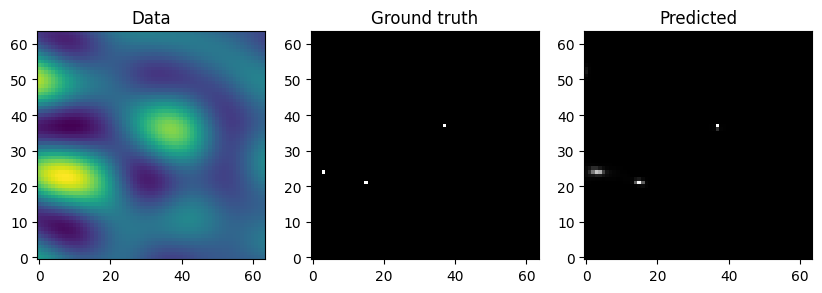

In [36]:

import matplotlib.animation as animation

real_sample_cur = 5

global sample_cur
sample_cur = mult * real_sample_cur

sample_inds = np.insert(np.cumsum(pt_cnts), 0, 0)

sample_size_px = 480
FOV_edge = sample_size_px / 2 - res / 2

step = 15

fig = plt.figure()

highligh_scat = False

imgs = processed_data[sample_cur]
masks = processed_masks[sample_cur]

real_sample_ind = sample_cur // mult

begin = sample_inds[real_sample_ind]
end = begin + pt_cnts[real_sample_ind]

real_step = sample_cur % mult
poss_step = step % poss.shape[0]

x = poss[real_step + poss_step, begin:end, 1]
y = poss[real_step + poss_step, begin:end, 0]

plt.subplot(1, 3, 1)
im1 = plt.imshow(imgs[step, :, :])
plt.axis([-0.5, res-0.5, -0.5, res-0.5])
if highligh_scat:
    scat = plt.scatter(x,y, c="red")
plt.title("Data")

plt.subplot(1, 3, 2)
im2 = plt.imshow(masks[step, :, :], cmap = "Greys_r")
plt.axis([-0.5, res-0.5, -0.5, res-0.5])
plt.title("Ground truth")    

plt.subplot(1, 3, 3)
im3 = plt.imshow(np.power(predictions[sample_cur, 0, :, :], 1/nthr), cmap = "Greys_r")
plt.axis([-0.5, res-0.5, -0.5, res-0.5])
plt.title("Predicted")
plt.show()

def updatefig(args):
    global sample_cur
    sample_cur += 1
    
    im1.set_array(processed_data[sample_cur, step, :, :])
    im2.set_array(processed_masks[sample_cur, step, :, :])
    im3.set_array(np.power(predictions[sample_cur, 0, :, :], 1/nthr))
    
    real_sample_ind = sample_cur // mult
    begin = sample_inds[real_sample_ind]
    end = begin + pt_cnts[real_sample_ind]

    real_step = sample_cur % mult

    x = poss[real_step + step, begin:end, 1]
    y = poss[real_step + step, begin:end, 0]
    
    if highligh_scat:
        scat.set_offsets(np.array([x, y]).T)
    
    return im1, im2, im3#, scat

anim = animation.FuncAnimation(fig, updatefig, interval=100, blit=True, repeat = True, frames = mult - 20)
anim.save('visualizations/predict_movie_' + str(real_sample_cur) + '.mp4', writer = 'ffmpeg', fps = 20)